In [41]:
%pip install scipy numpy matplotlib pyyaml --quiet

Note: you may need to restart the kernel to use updated packages.


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os

In [43]:
def get_params(config):
    try:
        # Acessa as configurações aninhadas
        ds = config['DATASET']
        rf = config['RF_FRONT_END']
        gps = config['GPS_STANDARD']
        acq = config['ACQUISITION']

        # 1. Extração de Variáveis Base (Conversão de Tipo)
        
        FILENAME = ds['FILENAME']
        # Converte a string 'int8' para o tipo numpy.int8
        DATA_DTYPE = getattr(np, ds['DTYPE']) 
        PRN_ID_TO_SEARCH = ds['PRN_ID_TO_SEARCH']
        
        FS = rf['FS']
        FIF = rf['FIF']
        
        PRN_CHIP_RATE = gps['PRN_CHIP_RATE']
        PRN_LENGTH = gps['PRN_LENGTH']
        
        DOPPLER_RANGE = acq['DOPPLER_RANGE']
        DOPPLER_STEP = acq['DOPPLER_STEP']
        TIME_TO_PROCESS = acq['TIME_TO_PROCESS']

        # 2. Cálculo de Parâmetros Derivados
        
        # Amostras por Chip (define o superamostragem da réplica do código)
        SAMPLES_PER_CHIP = round(FS / PRN_CHIP_RATE)

        # Alguns arquivos de configuração podem fornecer PRN_LENGTH já em amostras
        # (ex: 16368 = 1023 chips * 16 amostras/chip). Detectamos esse caso e
        # convertemos para número de chips para manter consistência interna.
        raw_prn_length = PRN_LENGTH
        if raw_prn_length > 2000:
            PRN_LENGTH = int(raw_prn_length // SAMPLES_PER_CHIP)

        # Amostras em um Período de Código (em amostras)
        SAMPLES_PER_CODE = PRN_LENGTH * SAMPLES_PER_CHIP

        # Número de Amostras para Integração Coerente (idealmente 1ms ou múltiplo)
        N_SAMPLES_COHERENT = int(FS * TIME_TO_PROCESS)

        # Garante que o bloco de amostras seja um múltiplo exato do período do código,
        # essencial para a correlação cíclica (FFT).
        N_SAMPLES_COHERENT = (N_SAMPLES_COHERENT // SAMPLES_PER_CODE) * SAMPLES_PER_CODE

        # Se o bloco calculado for 0 (por exemplo TIME_TO_PROCESS muito curto),
        # faça fallback para processar ao menos um período de código (evita FFT de tamanho 0)
        if N_SAMPLES_COHERENT == 0:
            N_SAMPLES_COHERENT = SAMPLES_PER_CODE

        # 3. Retorno das Constantes
        return {
            'FILENAME': FILENAME, 
            'DTYPE': DATA_DTYPE, 
            'PRN_ID_TO_SEARCH': PRN_ID_TO_SEARCH,
            'FS': FS, 
            'FIF': FIF, 
            'PRN_CHIP_RATE': PRN_CHIP_RATE, 
            'PRN_LENGTH': PRN_LENGTH,
            'DOPPLER_RANGE': DOPPLER_RANGE, 
            'DOPPLER_STEP': DOPPLER_STEP, 
            'TIME_TO_PROCESS': TIME_TO_PROCESS,
            'SAMPLES_PER_CHIP': SAMPLES_PER_CHIP,
            'SAMPLES_PER_CODE': SAMPLES_PER_CODE,
            'N_SAMPLES_COHERENT': N_SAMPLES_COHERENT
        }
    
    except KeyError as e:
        # Captura erros se uma chave essencial não estiver no arquivo de configuração
        raise KeyError(f"Erro: Chave de configuração ausente ou incorreta: {e}")
    except Exception as e:
        # Captura erros gerais, como falha na conversão de tipo (ex: 'FS' não é um número)
        raise Exception(f"Erro ao processar constantes: {e}")

def load_config(config_file):
    try:
        with open(config_file, 'r') as f:
            # Usa safe_load para evitar a execução de código arbitrário
            config = yaml.safe_load(f)
        return config
    except FileNotFoundError:
        raise FileNotFoundError(f"Erro: Arquivo de configuração '{config_file}' não encontrado.")
    except yaml.YAMLError as e:
        raise ValueError(f"Erro ao decodificar YAML: {e}")

CONFIG_CLEAN_PATH = os.path.join("config", "fgi", "config_clean.yaml")
CONFIG_DS2_PATH = os.path.join("config", "fgi", "config_spoofed.yaml")

config_clean_data = load_config(CONFIG_CLEAN_PATH)
config_ds2_data = load_config(CONFIG_DS2_PATH)

PARAMS_CLEAN = get_params(config_clean_data)
PARAMS_DS2 = get_params(config_ds2_data)

print(f"Amostras por chip (CLEAN): {PARAMS_CLEAN['SAMPLES_PER_CHIP']}")
print(f"Amostras por chip (DS2): {PARAMS_DS2['SAMPLES_PER_CHIP']}")

Amostras por chip (CLEAN): 25
Amostras por chip (DS2): 25


In [44]:
def desmodulate(gps_complex, N_samples, Fs, Fif_local):
    """
    Move o sinal para banda base usando a frequência local Fif_local.
    """
    t = np.arange(N_samples) / Fs
    local_carrier = np.exp(-1j * 2 * np.pi * Fif_local * t)
    return gps_complex * local_carrier
# --- 1. Mapeamento dos Taps G2 (Baseado no seu código) ---
# O índice da linha corresponde ao PRN ID (1 a 37).
# Os valores nos vetores são os estágios do G2 que são combinados com G1.
PRN_G2_TAPS = [
    [2, 6], [3, 7], [4, 8], [5, 9], [1, 9], [2, 10], [1, 8], [2, 9], 
    [3, 10], [2, 3], [3, 4], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], 
    [1, 4], [2, 5], [3, 6], [4, 7], [5, 8], [6, 9], [1, 3], [4, 6], 
    [5, 7], [6, 8], [7, 9], [8, 10], [1, 6], [2, 7], [3, 8], [4, 9], 
    [5, 10], [4, 10], [1, 7], [2, 8], [4, 10]
]

def generate_ca_code(prn_id, samples_per_chip, code_length=1023):
    sv_index = prn_id - 1

    if prn_id < 1 or prn_id > len(PRN_G2_TAPS):
        raise ValueError("PRN ID inválido (fora do intervalo 1-37).")

    # Inicialização: G1 e G2 com todos os 1s (usando 0/1 para lógica binária)
    LFSR_LEN = 10
    g1 = np.ones(LFSR_LEN, dtype=int)
    g2 = np.ones(LFSR_LEN, dtype=int)

    ca_code_chips = np.zeros(code_length, dtype=int)

    # Taps G2 específicas do satélite (posições de 1 a 10)
    g2_taps = PRN_G2_TAPS[sv_index]

    for i in range(code_length):
        # Saída dos registradores
        out_g1 = g1[9]
        out_g2 = g2[g2_taps[0] - 1] ^ g2[g2_taps[1] - 1]

        ca_chip_binary = out_g1 ^ out_g2
        ca_code_chips[i] = ca_chip_binary

        # Feedbacks
        feedback_g1 = g1[2] ^ g1[9]
        feedback_g2 = g2[1] ^ g2[2] ^ g2[5] ^ g2[7] ^ g2[8] ^ g2[9]

        g1 = np.roll(g1, 1)
        g1[0] = feedback_g1

        g2 = np.roll(g2, 1)
        g2[0] = feedback_g2

    # Conversão de chips binários (0, 1) para bipolares (-1, +1)
    bipolar_code_chips = 2 * ca_code_chips - 1

    # superamostragem dos chips
    bipolar_code_chips = np.repeat(bipolar_code_chips, samples_per_chip)

    # Retorna os chips na taxa de chip (sem repetição)
    return bipolar_code_chips

In [45]:
def normalize_correlation_by_noise(correlation_magnitude, samples_per_code, prn_length):
    # A. Acha a posição exata e o valor do pico bruto
    phase = np.argmax(correlation_magnitude)
    peak_value_raw = correlation_magnitude[phase]

    # B. Define a largura de exclusão ao redor do pico (1.5 chips)
    # samples_per_code / prn_length é o mesmo que samples_per_chip.
    samples_per_chip = samples_per_code / prn_length
    exclude_samples = int(1.5 * samples_per_chip)
    
    # Define os limites de exclusão
    start = max(0, phase - exclude_samples)
    end = min(len(correlation_magnitude), phase + exclude_samples)
    
    # C. Calcula o Nível de Ruído (Noise Floor)
    
    # Concatena os valores antes e depois da área do pico
    noise_values = np.concatenate([correlation_magnitude[:start], correlation_magnitude[end:]])
    
    # Usa a MEDIANA como medida robusta do chão de ruído (Noise Floor)
    if len(noise_values) == 0:
        # Fallback se o array for muito pequeno
        noise_level = np.median(correlation_magnitude) 
    else:
        noise_level = np.median(noise_values)

    # D. Normalização
    if noise_level < 1e-9: # Evita divisão por zero ou por um número muito pequeno
        noise_level = 1e-9

    corr_normalized = correlation_magnitude / noise_level

    # E. Valor do pico normalizado (SNR do Pico)
    peak_normalized = corr_normalized[phase]

    return corr_normalized, peak_normalized, phase

def correlate_signals(band_base_signal, local_code_replica):

    N = len(band_base_signal)
    # Aplicar janela de Hanning para suavizar os picos negativos (zeros espectrais)
    window = np.hanning(N)
    #  Aplicar janela para suavizar os picos negativos (zeros espectrais)

    # 1. Transformar o sinal e a réplica do código
    fft_signal = np.fft.fft(band_base_signal)
    fft_code_replica = np.fft.fft(local_code_replica * window)

    # 2. Multiplicação no domínio da frequência (Correlação)
    fft_product = fft_signal * np.conjugate(fft_code_replica)
    
    # 3. IFFT e Magnitude
    correlation_result = np.fft.ifft(fft_product)
    
    return np.abs(correlation_result)

In [46]:
def plot_fourier_spectra(band_base_signal, local_code_replica, Fs):
    """
    Calcula e plota o espectro de magnitude (FFT) do sinal em banda base 
    e da réplica do código PRN.
    """
    N = len(band_base_signal)

    # Aplicar janela de Hanning para suavizar os picos negativos (zeros espectrais)
    window = np.hanning(N)
    
    # 1. Cálculo da FFT
    # A FFT do código PRN deve ser conjugada no domínio da frequência para a correlação, 
    # mas para a plotagem do espectro, usamos a magnitude simples.
    fft_signal = np.fft.fft(band_base_signal)
    fft_code = np.fft.fft(local_code_replica * window)
    
    # 2. Deslocamento de Frequência (FFT-shift)
    # Move a frequência zero (DC) para o centro do espectro.
    fft_signal_shifted = np.fft.fftshift(fft_signal)
    fft_code_shifted = np.fft.fftshift(fft_code)
    
    # 3. Cálculo da Potência (Magnitude ao Quadrado ou apenas Magnitude em dB)
    # Usamos o logaritmo da magnitude (em dB) para visualizar melhor a faixa dinâmica.
    spectrum_signal = 10 * np.log10(np.abs(fft_signal_shifted) + 1e-10) # +1e-10 para evitar log(0)
    spectrum_code = 10 * np.log10(np.abs(fft_code_shifted) + 1e-10)
    
    # 4. Geração do Eixo de Frequência
    # O eixo de frequência vai de -Fs/2 até +Fs/2
    freq_axis = np.fft.fftshift(np.fft.fftfreq(N, d=1/Fs))
    
    plt.figure(figsize=(12, 6))
    
    # Plotagem do Espectro do Código PRN
    plt.plot(freq_axis / 1e6, spectrum_code, color='orange', label='Espectro da Réplica do Código PRN')
    
    # Plotagem do Espectro do Sinal em Banda Base (com Ruído)
    plt.plot(freq_axis / 1e6, spectrum_signal, color='blue', label='Espectro do Sinal GNSS em Banda Base')
    
    plt.title('Espectro de Frequência dos Sinais (Domínio de Frequência)')
    plt.xlabel('Frequência (MHz)')
    plt.ylabel('Magnitude (dB)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [47]:
def acquire_gnss_signal(filepath):

    print(f"\nIniciando aquisição GNSS para o arquivo: {filepath}\n")

    filename = os.path.basename(filepath)

    if "clean" in filename:
        cfg = PARAMS_CLEAN
    elif "TGS" in filename:
        cfg = PARAMS_DS2

    # --- 1. Leitura e Preparação do Sinal ---
    try:
        print(cfg["DTYPE"])
        required_real_elements = cfg["N_SAMPLES_COHERENT"]
        raw_data = np.fromfile(filepath, dtype=cfg["DTYPE"], count=required_real_elements)

        # Intercalação: I = [0, 2, 4...], Q = [1, 3, 5...]
        I_samples = raw_data.astype(np.float32)
        Q_samples = np.zeros_like(I_samples)  # Placeholder for Q samples
        gps_complex = I_samples + 1j * Q_samples
        print(raw_data[:10])

        N_total = len(gps_complex)//50

        print("Plotando amostra lida do sinal")

        plt.figure(figsize=(12, 4))
        plt.plot(np.real(gps_complex[:N_total]), label="I (Real)")
        plt.plot(np.imag(gps_complex[:N_total]), label="Q (Imag)")
        plt.title("Sinal no domínio do tempo (I/Q)")
        plt.xlabel("Amostra")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(12, 4))
        plt.plot(np.fft.fft(np.real(gps_complex[:N_total])), label="I (Real)")
        plt.plot(np.fft.fft(np.imag(gps_complex[:N_total])), label="Q (Imag)")
        plt.title("Espectro de Frequência do Sinal (I/Q)")
        plt.xlabel("Frequência (Hz)")
        plt.ylabel("Magnitude")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Usaremos apenas um bloco coerente
        gps_segment = gps_complex[:cfg["N_SAMPLES_COHERENT"]]
        N_segment = len(gps_segment)

        if len(raw_data) < required_real_elements:
                n_samples = cfg["N_SAMPLES_COHERENT"]
                print(f"Erro: Arquivo muito curto. Lido {len(raw_data)//2} amostras complexas.")
                print(f"Necessário {n_samples} amostras complexas para {cfg['TIME_TO_PROCESS'] * 1000:.1f} ms.")
                return
        
        print(f"\nSinal lido e segmentado: {N_segment} amostras.")
    except FileNotFoundError:
        print(f"Erro: Arquivo '{filepath}' não encontrado.")
        return

    # --- 3. Busca Bidimensional (2D) ---
    max_correlation_value = 0.0
    best_doppler = 0.0
    best_tau = 0
    right_prn = 0
    best_code_replica = None
    
    # Define a faixa de frequências a testar
    doppler_freqs = np.arange(-cfg["DOPPLER_RANGE"], cfg["DOPPLER_RANGE"] + cfg["DOPPLER_STEP"], cfg["DOPPLER_STEP"])
    for prn in range(1, 33):
        print(f"Iniciando busca para PRN {prn}...")
        local_code_chips = generate_ca_code(prn, cfg["SAMPLES_PER_CHIP"], cfg["PRN_LENGTH"])
        local_code_replica = np.tile(local_code_chips, N_segment // cfg["SAMPLES_PER_CODE"])

        for doppler in doppler_freqs:
            # A frequência local de desmodulação varia o Doppler
            Fif_local = cfg["FIF"] + doppler
            
            # Desmodula o sinal para banda base (remove Fif e o Doppler de teste)
            band_base_signal = desmodulate(gps_segment, N_segment, cfg["FS"], Fif_local)
            
            if prn == 1 and doppler == doppler_freqs[0]:
                plt.figure(figsize=(12, 4))
                plt.plot(np.fft.fft(np.real(band_base_signal[:N_total])), label="I (Real)")
                plt.plot(np.fft.fft(np.imag(band_base_signal[:N_total])), label="Q (Imag)")
                plt.title("Espectro de Frequência do Sinal Desmodulado (I/Q)")
                plt.xlabel("Frequência (Hz)")
                plt.ylabel("Magnitude")
                plt.legend()
                plt.grid(True)
                plt.show()

            # Correlação com o código PRN local (Busca no atraso tau)
            correlation_magnitude = correlate_signals(band_base_signal, local_code_replica)
            
            # Encontra o pico de correlação nesta frequência Doppler
            current_max = np.max(correlation_magnitude)
            
            if current_max > max_correlation_value:
                max_correlation_value = current_max
                best_doppler = doppler
                # O índice do pico é o atraso de código (tau)
                best_tau = np.argmax(correlation_magnitude)
                right_prn = prn 
                best_code_replica = local_code_replica.copy()
                
    # --- 4. Resultados e Plotagem ---
    
    print("\n--- Resultado da Aquisição ---")
    print(f"PRN Adquirido: {right_prn}")
    print(f"Doppler Encontrado (Freq.): {best_doppler:.1f} Hz")
    
    # O atraso $\tau$ é o índice de amostra. Convertendo para chips:
    tau_chips = best_tau / cfg["SAMPLES_PER_CHIP"]
    print(f"Atraso de Código Encontrado ($\\tau$): {tau_chips:.2f} chips")
    print(f"Valor do Pico de Correlação: {max_correlation_value:.2f}")

    # Plotagem (Re-correlaciona no melhor ponto para plotar)
    final_fif_local = cfg["FIF"] + best_doppler
    final_band_base = desmodulate(gps_segment, N_segment, cfg["FS"], final_fif_local)
    final_correlation = correlate_signals(final_band_base, best_code_replica)
    corr_normalized, peak_normalized, phase = normalize_correlation_by_noise(final_correlation, cfg['N_SAMPLES_COHERENT'], cfg['PRN_LENGTH'])
    
    # 2. Recalcula os valores do pico usando o resultado NORMALIZADO
    
    # Atraso em chips (calculado a partir da posição 'phase')
    tau_chips_normalized = phase / cfg["SAMPLES_PER_CHIP"]
    
    # Eixo X: Atraso em Chips (permanece o mesmo)
    tau_axis = np.arange(len(final_correlation)) / cfg["SAMPLES_PER_CHIP"]
    
    # 3. Plotagem
    plt.figure(figsize=(10, 5))
    
    # Plota a curva normalizada (eixo Y agora representa a razão Sinal/Ruído)
    plt.plot(tau_axis, corr_normalized, color='green') 
    
    # Plota o ponto do pico usando os valores normalizados
    plt.scatter(
        tau_chips_normalized, 
        peak_normalized, 
        color='red', 
        s=100, 
        zorder=5, 
        label=f'Pico (SNR = {peak_normalized:.2f})'
    )
    
    # Linha Horizontal em 1.0 (o Chão de Ruído Normalizado)
    plt.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, label='Noise Floor (1.0)')
    
    plt.title(f'Pico de Correlação (PRN {right_prn}) Normalizado')
    plt.xlabel('Atraso de Código ($\tau$) em Chips')
    plt.ylabel('Relação Sinal-Ruído (Magnitude Normalizada)')
    plt.xlim(0, cfg["PRN_LENGTH"]) 
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 4. PLOTAGEM DO ESPECTRO DE FOURIER (ADICIONAL) ---
    print("\nPlotando Espectros de Frequência...")
    plot_fourier_spectra(final_band_base, best_code_replica, cfg["FS"])


Iniciando aquisição GNSS para o arquivo: /home/rc-2d/Downloads/gnss-dataset/OSNMA_cleandata_opensky_460s.dat

<class 'numpy.int8'>
[ 1  3 -1 -3  1  3 -1  1  1 -1]
Plotando amostra lida do sinal


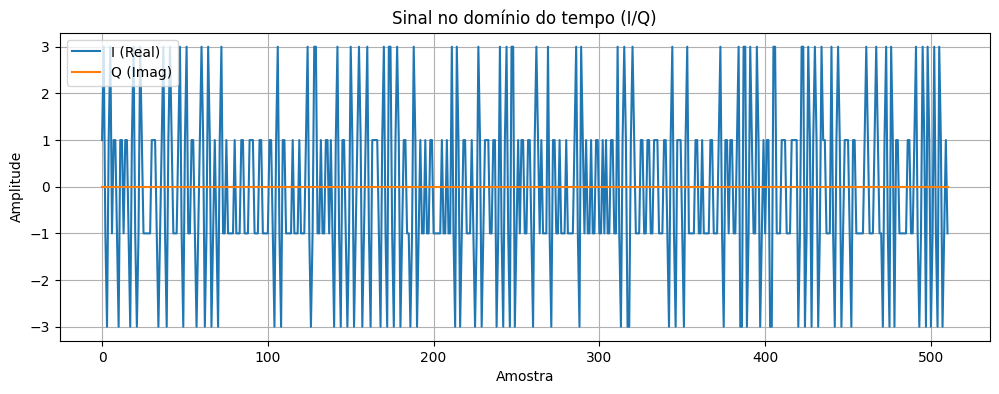

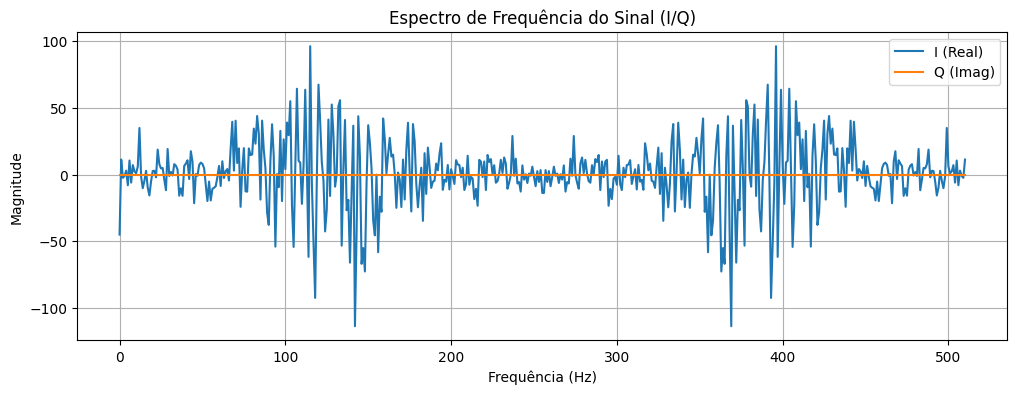


Sinal lido e segmentado: 25575 amostras.
Iniciando busca para PRN 1...


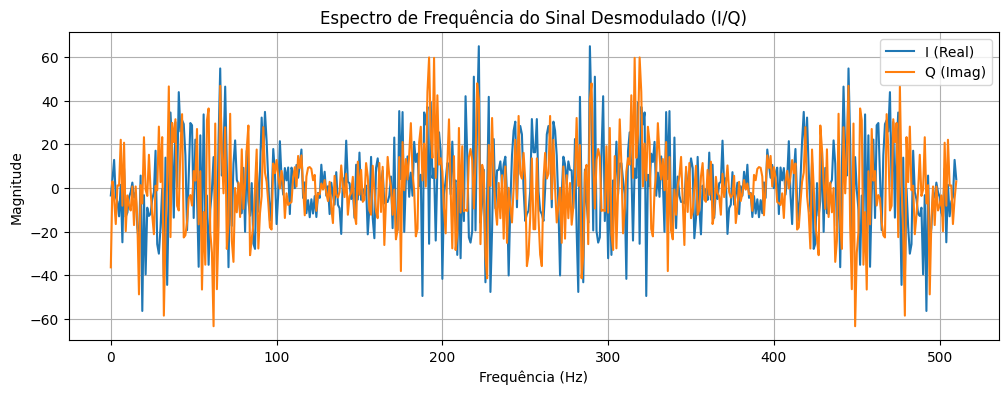

Iniciando busca para PRN 2...
Iniciando busca para PRN 3...
Iniciando busca para PRN 4...
Iniciando busca para PRN 5...
Iniciando busca para PRN 6...
Iniciando busca para PRN 7...
Iniciando busca para PRN 8...
Iniciando busca para PRN 9...
Iniciando busca para PRN 10...
Iniciando busca para PRN 11...
Iniciando busca para PRN 12...
Iniciando busca para PRN 13...
Iniciando busca para PRN 14...
Iniciando busca para PRN 15...
Iniciando busca para PRN 16...
Iniciando busca para PRN 17...
Iniciando busca para PRN 18...
Iniciando busca para PRN 19...
Iniciando busca para PRN 20...
Iniciando busca para PRN 21...
Iniciando busca para PRN 22...
Iniciando busca para PRN 23...
Iniciando busca para PRN 24...
Iniciando busca para PRN 25...
Iniciando busca para PRN 26...
Iniciando busca para PRN 27...
Iniciando busca para PRN 28...
Iniciando busca para PRN 29...
Iniciando busca para PRN 30...
Iniciando busca para PRN 31...
Iniciando busca para PRN 32...

--- Resultado da Aquisição ---
PRN Adquirido: 

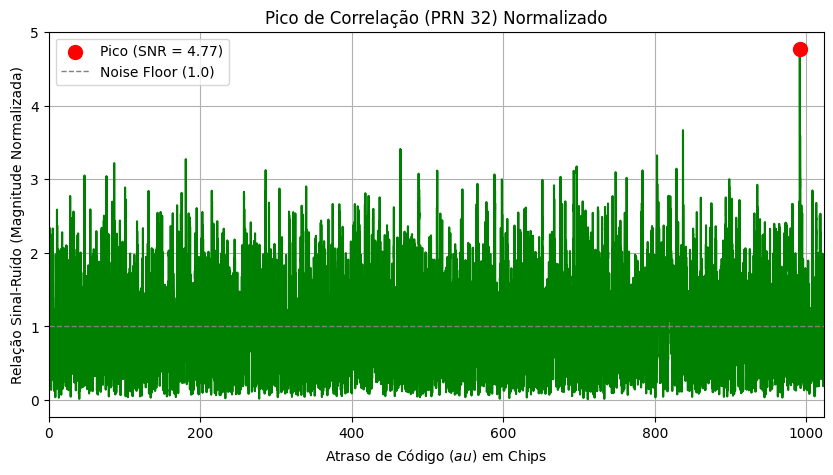


Plotando Espectros de Frequência...


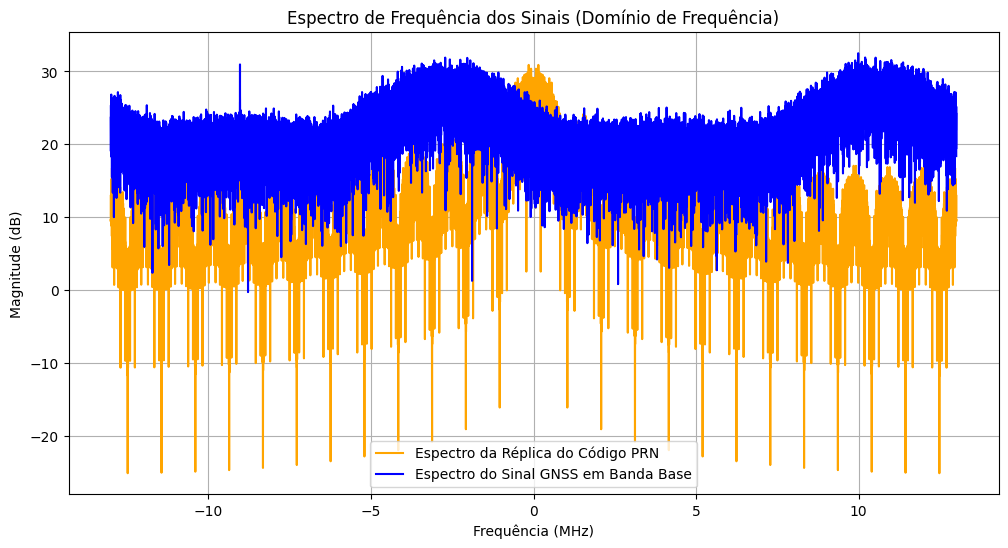


Iniciando aquisição GNSS para o arquivo: /home/rc-2d/Downloads/gnss-dataset/TGS_L1_E1.dat

<class 'numpy.int8'>
[-1 -1  1  1 -1 -3  1  1 -1  1]
Plotando amostra lida do sinal


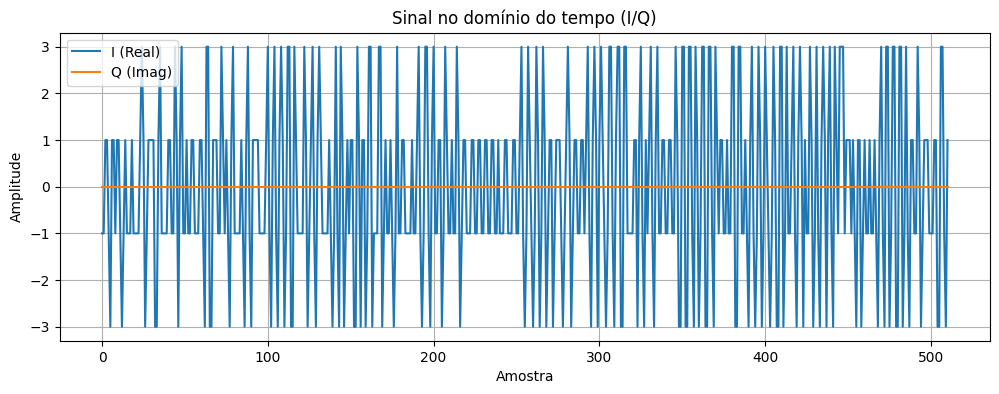

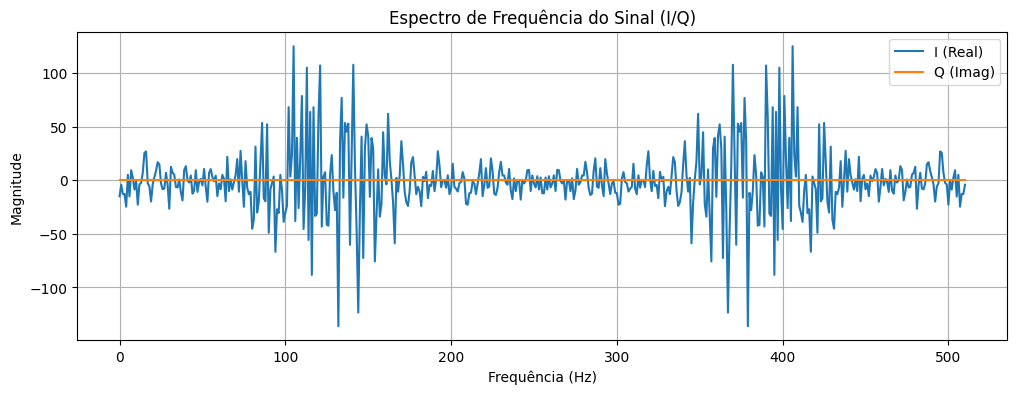


Sinal lido e segmentado: 25575 amostras.
Iniciando busca para PRN 1...


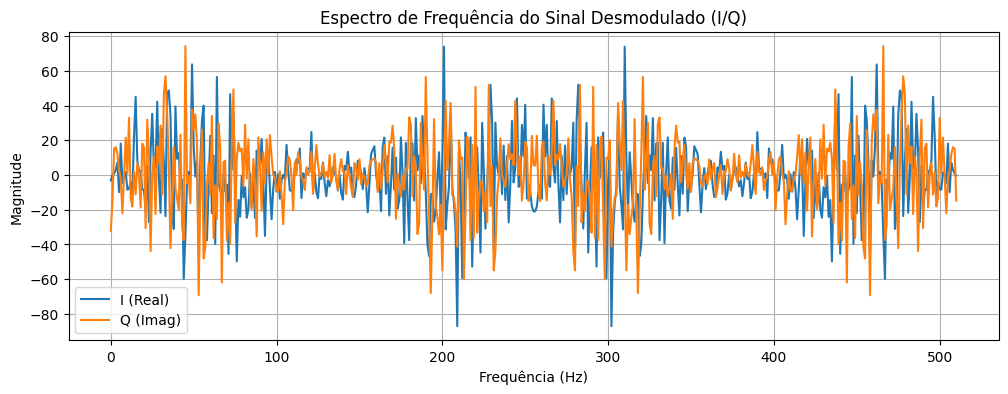

Iniciando busca para PRN 2...
Iniciando busca para PRN 3...
Iniciando busca para PRN 4...
Iniciando busca para PRN 5...
Iniciando busca para PRN 6...
Iniciando busca para PRN 7...
Iniciando busca para PRN 8...
Iniciando busca para PRN 9...
Iniciando busca para PRN 10...
Iniciando busca para PRN 11...
Iniciando busca para PRN 12...
Iniciando busca para PRN 13...
Iniciando busca para PRN 14...
Iniciando busca para PRN 15...
Iniciando busca para PRN 16...
Iniciando busca para PRN 17...
Iniciando busca para PRN 18...
Iniciando busca para PRN 19...
Iniciando busca para PRN 20...
Iniciando busca para PRN 21...
Iniciando busca para PRN 22...
Iniciando busca para PRN 23...
Iniciando busca para PRN 24...
Iniciando busca para PRN 25...
Iniciando busca para PRN 26...
Iniciando busca para PRN 27...
Iniciando busca para PRN 28...
Iniciando busca para PRN 29...
Iniciando busca para PRN 30...
Iniciando busca para PRN 31...
Iniciando busca para PRN 32...

--- Resultado da Aquisição ---
PRN Adquirido: 

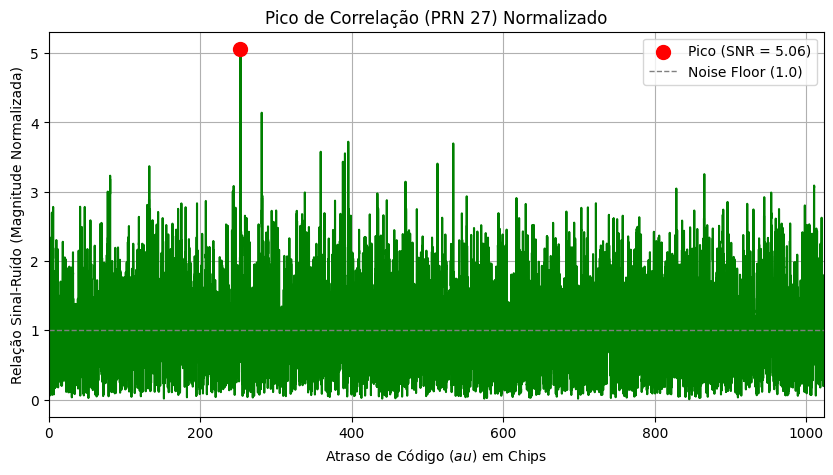


Plotando Espectros de Frequência...


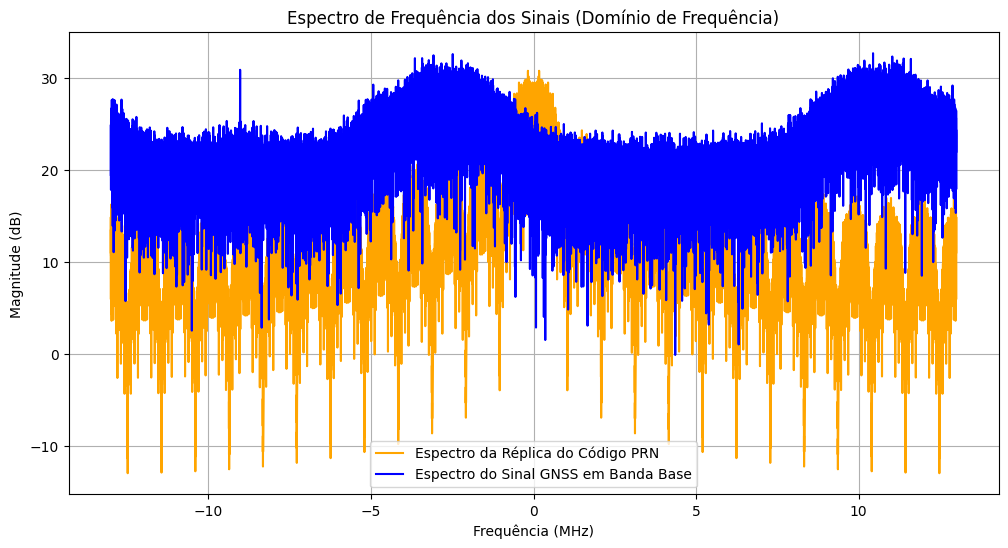

In [48]:
FILENAME_CLEAN = '/home/rc-2d/Downloads/gnss-dataset/OSNMA_cleandata_opensky_460s.dat'
FILENAME_SPOOFED = '/home/rc-2d/Downloads/gnss-dataset/TGS_L1_E1.dat'

# 2. Executar o processo de aquisição (busca 2D)
acquire_gnss_signal(FILENAME_CLEAN)
acquire_gnss_signal(FILENAME_SPOOFED)